# Purified evolution of 1 site coupled to bath
TDVP unitary evolution of a purified density matrix

In [3]:
using ITensors
using ITensorTDVP
using Plots 
using Observers
using LinearAlgebra
using Statistics

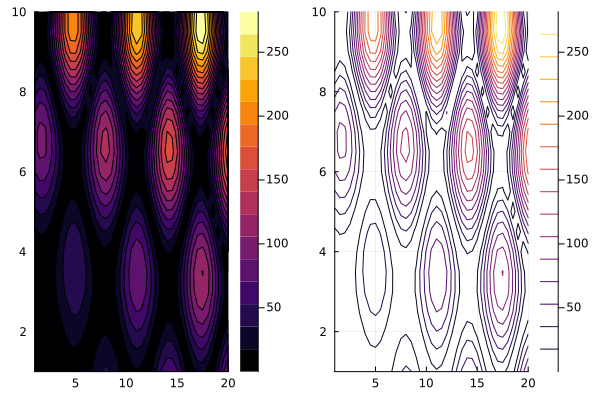

In [4]:

x = 1:0.5:20
y = 1:0.5:10
f(x, y) = begin
        (3x + y ^ 2) * abs(sin(x) + cos(y))
    end
p1 = contour(x, y, f, fill = true,legend=true)
p2 = contour(x, y, f)
plot(p1, p2)

In [4]:
function entanglement_entropy(ψ)
# Compute the von Neumann entanglement entropy across each bond of the MPS
    N = length(ψ)
    SvN = zeros(N)
    psi = ψ
    for b=1:N
        psi = orthogonalize(psi, b)
        if b==1
            U,S,V = svd(psi[b] , siteind(psi, b))
        else
            U,S,V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))
        end
        for n=1:dim(S, 1)
            p = S[n,n]^2
            SvN[b] -= p * log2(p)
        end
    end
    return SvN
end;

function spectral_density(J,Nb,Γ,D)
    ###Need to sort V_k the same way as the energies
    
    x_k = collect(range(-1, 1, length = Nb))
    if J== "boxcar"
        V_k = sqrt(Γ/(2*D))*ones(Nb,1)                       # Couplings
        ϵb = collect(range(-1, 1, length = Nb))              # energy of bath modes
    end
    ind = sortperm(abs.(ϵb))                               # Broadcast abs() over vector using "." notation.
    V_k, ϵb = V_k[ind], ϵb[ind];  
    return V_k, ϵb
end

function rdm(ψ,q)
    ψdag = dag(ψ) # Complex conjugate MPS
    ITensors.prime!(linkinds, ψdag) # Add primes to all MPS bond indices
    # Loop over the sites q whose density matrix is required:
    for j=1:length(q)
        ITensors.noprime!(ψdag[q[j]]) # Remove prime on bond indices of ψdag[q[j]]
        ITensors.prime!(ψdag[q[j]]) # Prime all indices on ψdag[q[j]] including its site index
    end
    # Now contract:
    ρ = ψdag[1] * ψ[1]
    for j in 2:N
      ρ = ρ * ψdag[j] * ψ[j]
    end
    return ρ
end;


###Observer functions
function current_time(; current_time, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return real(im*current_time)
  end
  return nothing
end

function measure_den(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return expect(psi, "n"; sites=1)
  end
  return nothing
end;

function measure_SvN(; psi, bond, half_sweep)
    if bond == 1 && half_sweep == 2
        return entanglement_entropy(psi)
    end
    return nothing
end

function measure_correlation_matrix(; psi, bond, half_sweep)
    if bond==1 && half_sweep == 2
        return correlation_matrix(psi,"Cdag","C")
    end
    return nothing
end

# function get_sw_time(; sweep,bond, half_sweep)
#     if bond==1 && half_sweep == 2
#         sw_time = @elapsed begin
#         psi, PH, info = tdvp_step(
#         tdvp_order,
#         solver,
#         PH,
#         time_step,
#         psi;
#         current_time,
#         reverse_step,
#         sweep,
#         maxdim=maxdim[sweep],
#         mindim=mindim[sweep],
#         cutoff=cutoff[sweep],
#         noise=noise[sweep],
#       )
#         end
#         return sw_time
#     end
#     return nothing
# end
    





function band_diag(B,d)
# Band-diagonalize matrix B with a bandwidth of d:
    n = size(B,1); # Assumed to be square.
    U = Diagonal(ones(n,n));
    for k=1:Int(floor(n/d)-1)
      C = B[(k*d+1):n,((k-1)*d+1):(k*d)]; # Extract coupling matrix.
      F = qr(C); # Upper-triangularize.
      blocks = [[Diagonal(ones(k*d,k*d))]; [F.Q']]
      Q = cat(blocks...,dims=(1,2))    # Form full triangularizing unitary.    
      B = Q*B*Q'; # Apply to input matrix to transform for next step.
      U = Q*U; # Save this step's unitary to the full sequence.
    end
    return B; # Return the final band-diagonalized matrix.
end;

function graphing(ψ_list)
    n1 = length(ψ_list[1])
    n2 = length(ψ_list)
    SvN_list,density_list = zeros(n1,n2),zeros(n1,n2)
    
    gr()
    for i=1:n2
        SvN_list[:,i] = entanglement_entropy(ψ_list[i])
        density_list[:,i] = expect(ψ_list[i],"n")
    end  
    display(plot(sites, SvN_list,label="Entanglement entropy"))
    display(plot(sites,density_list,label="Density"))
    
end;

function correlation_matrix_statistics(Cf,Cf_test,eps)
    trun_ind1 = findall(x -> (abs(x)>eps), Cf)
    trun_ind2 = findall(x -> (abs(x)>eps), Cf_test)
    bool = size(trun_ind1)[1]>size(trun_ind2)[1]
    if bool
        trun_ind = trun_ind1
    else
        trun_ind = trun_ind2
    end
    Cf_trun = Cf[trun_ind]
    Cf_test_trun = Cf_test[trun_ind]
    Cf_trun_diff = Cf_trun-Cf_test_trun
    println("mean of truncated difference correlation matrix="*string(mean(broadcast(abs,Cf_trun_diff))))
    println("std of truncated difference correlation matrix="*string(std(broadcast(abs,Cf_trun_diff))))
    println("mean of truncated Cf="*string(mean(broadcast(abs,Cf_trun))))
    println("mean of truncated Cf_test="*string(mean(broadcast(abs,Cf_test_trun))))
    
    #plot(real(Cf[:,2]))
    #plot!(real(Cf_test[:,2]))
    #plot!(broadcast(abs,Cf[:,2]-Cf_test[:,2]))
    
    f(x, y) = abs(Cf[x,y])

    surface(1:20,1:20,f,title = "Simulated Correlation matrix",
    xlabel = "sites",
    ylabel = "sites")
    
    g(x, y) = abs(Cf[x,y]-Cf_test[x,y])

    surface(1:50,1:50,g,title = "Difference between simulated and exact",
    xlabel = "sites",
    ylabel = "sites")

end

# function correlation_animations(corr, n, site_lim)
#     ###Can't work out how to plot both contour plots and surface plots in same gif loop
#     default(legend=false)
#     x=y=1:site_lim
#     @gif for i=1:n
#         f(x, y) = abs((corr[i])[x,y])
#         p=plot(x,y,f,st=[:surface, :contourf],layout=2)
#         #p = surface(x, y, f,aspect_ratio=:equal,zlim=(0,corr_zlim),
#             # xlabel="sites",ylabel="sites")
#         #q = contour(x, y, f,xlabel="sites",ylabel="sites",
#              #title="animation of correlation matrix over time")
#         #plot(p)
#         #plot(q)
#     end
        
# end

function correlation_heatmap(corr, n, site_lim)
    x=y=1:site_lim
    @gif for i=1:n
        f(x, y) = abs((corr[i])[x,y])
        hetamap(x,y,f,size=(400,400),aspect_ratio=:equal,clims=(0, 1))
        #plot(contour(x, y,xlabel="sites",ylabel="sites",
             #title="animation of correlation matrix over time",c=:blues))
    end
end

function correlation_contour(corr, n, site_lim)
    x=y=1:site_lim
    @gif for i=1:n
        f(x, y) = abs((corr[i])[x,y])
        contour(x,y,f,size=(400,400),aspect_ratio=:equal,clims=(0, 1))
        #plot(contour(x, y,xlabel="sites",ylabel="sites",
             #title="animation of correlation matrix over time",c=:blues))
    end
end

function correlation_surface_plot(corr, n, site_lim)
    default(legend=false)
    x=y=1:site_lim
    @gif for i=1:n
        f(x, y) = abs((corr[i])[x,y])
        surface(x, y, f,zlim=(0,1),xlabel="sites",ylabel="sites",
             title="animation of correlation matrix over time", c = :blues)
    end
end

function entanglement_animation(SvN, n, site_lim, SvN_ylim)
    
    @gif for i=1:n
        plot(sites[1:site_lim],SvN[i][1:site_lim],ylim=(0,SvN_ylim),
        xlabel="sites",ylabel="entanglement entropy")
    end
end


entanglement_animation (generic function with 1 method)

In [16]:
# T=10
# n = Int(T/δt)
# site_lim = 30
# corr_zlim = 1

# x=y=1:site_lim
#     @gif for i=1:n
#         f(x, y) = abs((corr[i])[x,y])
#         surface(x,y,f,size=(400,400),aspect_ratio=:equal,clims=(0, 1))
#         #plot(contour(x, y,xlabel="sites",ylabel="sites",
#              #title="animation of correlation matrix over time",c=:blues))
#     end




# # #SvN_ylim=5
# # entanglement_animation(SvN, n, site_lim, SvN_ylim)




In [6]:
J = "boxcar"                                   #choice of bath spectral function
N = 100                                       # Number of sites
cutoff = 1E-12                               # Truncation allowed per step
s = siteinds("Fermion", N)                   # Array of site indices  
sites = 1:N                                  # site list
δt = 0.1                                     # Time-step
T = 1.0;                                     # Total time
β = 0                                        #inverse temperature
ϵi = 0.5;                                      # energy of impurity mode
Nb = Int((N-2)/2)                            # number of bath modes
D = 10                                       #half bandwidth
Γ = 0.1                                      # total impurity-bath cϵstrength
t = sqrt(Γ/(pi * Nb)) 
V_k, ϵb = spectral_density(J,Nb,Γ,D)                        
f_k = 1 ./(1 .+exp.(β*ϵb))                     # Fermi distributions of the bath modes



###Construct arrays of local operators

c = ops(s, [("C", n) for n in sites]);        # annihilation operators
cd = ops(s, [("Cdag", n) for n in sites]);    # creation operators
Imat = [1.0 0.0; 0.0 1.0]                     # identity matrix
Id = Vector{ITensor}(undef,N)
for i=1:N
   Id[i] = ITensor(Imat,s[i]',s[i])           # identiy operators
end;


###Constructs Initial state
vac = productMPS(s, "0");

print("bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3")

choice = parse(Int,readline())
if choice == 1
    #gates = [(cd[n]*Id[n+1] + Id[n]*cd[n+1])/sqrt(2) for n in 3:2:N]; 
    gates = [(sqrt(f_k[Int((n-1)/2)])*cd[n]*Id[n+1] + sqrt(1-f_k[Int((n-1)/2)])*Id[n]*cd[n+1])/sqrt(2) for n in 3:2:N]; 
end

if choice==2 || choice==3
     gates = [cd[n]*Id[n+1] for n in 3:2:N]
     
end
system_gate = (cd[1]*Id[2] + Id[1]*cd[2])/sqrt(2)
push!(gates,system_gate)
ψ = apply(gates,vac;cutoff=1e-15);



#The following code is not optimised, various objects are created multiple times
#and within each different option there is identical code which doesn't
#need to be written multiple times.




###Create Hamiltonian MPO 
terms = OpSum()
###Create single particle matrix hamiltonian
H_single = zeros(N,N)

### For all choices, the first two indices are the system ancilla and the system respectively.
terms += ϵi,"n",2;
H_single[2,2] = ϵi
b = 0


if choice ==1
    print("negative ancilla H = -1, no ancilla H = 0, positive anilla H = 1")
    HA_choice = parse(Int,readline())                          #choose between H_A =H_B,-H_B,0
    for j=3:2:N
        b += 1
        terms += ϵb[b],"n",j                                   # bath mode self energy
        H_single[j,j] = ϵb[b]
        
        terms += HA_choice*ϵb[b],"n",j+1                       # ancilla bath mode self energy
        H_single[j+1,j+1] =  HA_choice*ϵb[b]
        
        terms += V_k[b],"Cdag",j,"C",2                         #hopping from system to kth f mode 
        H_single[j,2] = V_k[b]
        
        terms += conj(V_k[b]),"Cdag",2,"C",j                   #hopping from kth f mode to system 
        H_single[2,j] = conj(V_k[b])
    end    
end

if choice==2

    for j=3:2:N
        b += 1
        terms += ϵb[b],"n",j                                   # bath mode self energy
        H_single[j,j] = ϵb[b]
        
        terms += ϵb[b],"n",j+1                                 # ancilla bath mode self energy
        H_single[j+1,j+1] =  ϵb[b]
        
        terms += V_k[b]*sqrt(f_k[b]),"Cdag",j,"C",2            #hopping from system to kth f mode
        H_single[j,2] = V_k[b]*sqrt(f_k[b])
        
        terms += conj(V_k[b])*sqrt(f_k[b]),"Cdag",2,"C",j      #hopping from kth f mode to system 
        H_single[2,j] = conj(V_k[b])*sqrt(f_k[b])
        
        terms += V_k[b]*sqrt(1-f_k[b]),"Cdag",j+1,"C",2        #coupling from system to kth e mode
        H_single[j+1,2] =  V_k[b]*sqrt(1-f_k[b])
        
        terms += conj(V_k[b])*sqrt(1-f_k[b]),"Cdag",2,"C",j+1  #coupling from kth e mode to system
        H_single[2,j+1] =  conj(V_k[b])*sqrt(1-f_k[b])
    end
end

if choice ==3
    
    fill_mat = zeros(Nb+1,Nb+1)
    emp_mat = zeros(Nb+1,Nb+1)
    ### Same terms as for choice 2, inputed as a matrix rather than an MPO. 
    for j=1:Nb
        ###This loop creates two (Nb+1) x (Nb+1) matrices, one includes the couplings and self energies of the 
        ###filled modes and the system, the other the empty modes and the system. These are then tridiagonalised 
        ###separately in the next loop, and their elements are used to construct the MPO for the hamiltonian in this new, tridiagonal basis. 
    
        fill_mat[1,1],emp_mat[1,1] = ϵi, ϵi

        fill_mat[j+1,j+1],emp_mat[j+1,j+1] = ϵb[j],ϵb[j]

        fill_mat[j+1,1] = V_k[j]*sqrt(f_k[j])

        fill_mat[1,j+1] = conj(V_k[j])*sqrt(f_k[j])

        emp_mat[j+1,1] = V_k[j]*sqrt(1-f_k[j])

        emp_mat[1,j+1] = conj(V_k[j])*sqrt(1-f_k[j])
    end

    fill_mat = band_diag(fill_mat,1)
    emp_mat = band_diag(emp_mat,1)
    b = 1
    for j=3:2:N
        b += 1
        terms += fill_mat[b,b],"n",j
        H_single[j,j] = fill_mat[b,b]
        
        terms += emp_mat[b,b],"n",j+1
        H_single[j+1,j+1] = emp_mat[b,b]
        terms += emp_mat[b-1,b],"Cdag",j-1,"C",j+1
        H_single[j-1,j+1] = emp_mat[b-1,b]
        terms += emp_mat[b,b-1],"Cdag",j+1,"C",j-1
        H_single[j+1,j-1] = emp_mat[b,b-1]
        if j==3
            terms += fill_mat[b-1,b],"Cdag",2,"C",3
            H_single[2,3] = fill_mat[b-1,b]
            terms += fill_mat[b,b-1],"Cdag",3,"C",2
            H_single[3,2] = fill_mat[b,b-1]
        else
            terms += fill_mat[b-1,b],"Cdag",j-2,"C",j
            H_single[j-2,j] = fill_mat[b-1,b]
            terms += fill_mat[b,b-1],"Cdag",j,"C",j-2
            H_single[j,j-2] = fill_mat[b,b-1]
        end
    end
end
H = MPO(terms,s);



###Initial Correlations
Ci = correlation_matrix(ψ,"Cdag","C");

###Initial Entropy
SvN_init = entanglement_entropy(ψ);


###density of initial state
num_init = expect(ψ,"n");

###Initial state
ψ_init = ψ;


stdin>  3


bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3

In [208]:

println("Number Operator expectation values")
for j in sites
    # println(rpad(j,6," "),num_init[j])
end
display(plot(sites, SvN_init, label="ψ"))

gr()
display(heatmap(sites, sites, Ci, c = :heat))

In [8]:
obs = Observer("times" => current_time,"corr" => measure_correlation_matrix,"SvN" =>measure_SvN)#,"simulation times" => get_sw_time)
T = 10
ψf = tdvp(H,-im * T,ψ; time_step = -im * δt, cutoff, outputlevel=1, normalize=false, (observer!)=obs)

res = results(obs)
times = res["times"]
corr = res["corr"];
SvN = res["SvN"]
#display(plot(times, den, label="line"))
#display(scatter!(times, den, label="points"))

###exact propagation
###U*Ci*U' matches up well up to complex conjugation, so I assume U'*Ci*U is the correct answer,
###but I'm unsure why.
U= exp(-im*T*H_single);
Cf_test = U*Ci*U';


After sweep 1: maxlinkdim=4 maxerr=2.80E-14 current_time=0.0 - 0.1im time=58.092
After sweep 2: maxlinkdim=5 maxerr=3.30E-14 current_time=0.0 - 0.2im time=0.866
After sweep 3: maxlinkdim=6 maxerr=7.18E-14 current_time=0.0 - 0.3im time=1.198
After sweep 4: maxlinkdim=7 maxerr=2.88E-13 current_time=0.0 - 0.4im time=0.631
After sweep 5: maxlinkdim=7 maxerr=2.05E-13 current_time=0.0 - 0.5im time=0.629
After sweep 6: maxlinkdim=8 maxerr=1.34E-13 current_time=0.0 - 0.6im time=0.642
After sweep 7: maxlinkdim=8 maxerr=6.25E-13 current_time=0.0 - 0.7im time=0.735
After sweep 8: maxlinkdim=8 maxerr=6.41E-13 current_time=0.0 - 0.8im time=0.703
After sweep 9: maxlinkdim=9 maxerr=7.61E-14 current_time=0.0 - 0.9im time=0.824
After sweep 10: maxlinkdim=10 maxerr=3.80E-13 current_time=0.0 - 1.0im time=0.63
After sweep 11: maxlinkdim=11 maxerr=4.82E-13 current_time=0.0 - 1.1im time=0.636
After sweep 12: maxlinkdim=12 maxerr=2.78E-13 current_time=0.0 - 1.2im time=0.639
After sweep 13: maxlinkdim=12 maxe

In [12]:
n = Int(T/δt)
site_lim = 20
corr_zlim = 1
display(correlation_surface_plot(corr, n, site_lim, corr_zlim))
# #PUT IN HEATMAP


SvN_ylim=5
entanglement_animation(SvN, n, site_lim, SvN_ylim)


LoadError: MethodError: no method matching correlation_surface_plot(::Vector{Matrix{ComplexF64}}, ::Int64, ::Int64, ::Int64)
[0mClosest candidates are:
[0m  correlation_surface_plot(::Any, ::Any, ::Any) at In[4]:210

In [23]:
res["simulation time"][1]

1.665658975896238e9

In [46]:

f = h5open("MPS_for_15T_Thermo.h5","w")
write(f,"psis",list[2])
close(f)

1     0.5000000287692696
2     0.49994504529992095
3     0.8078461926331979
4     0.19213817073925052
5     0.7732099574779512
6     0.22658108479512648
7     0.7920508648929754
8     0.20804132094112518
9     0.8040050724414742
10    0.1963116234709288
11    0.8308659158361794
12    0.16932697905821542
13    0.8603470785992784
14    0.13986917344566205
15    0.8697134580632011
16    0.13185181708536003
17    0.891855306055622
18    0.10970566825833299
19    0.934174449932524
20    0.06611493780937083
21    0.9712505169483194
22    0.027080834016524783
23    0.9913068946998158
24    0.007179406467434365
25    0.9983843893374219
26    0.0009320327347001973
27    0.9999016166210999
28    1.0163569709782702e-5
29    0.9999999999999987
30    0.0
31    0.9999999999999987
32    0.0
33    0.9999999999999987
34    0.0
35    0.9999999999999987
36    0.0
37    0.9999999999999987
38    0.0
39    0.9999999999999987
40    0.0
41    0.9999999999999987
42    0.0
43    0.9999999999999987
44    0.0
45 

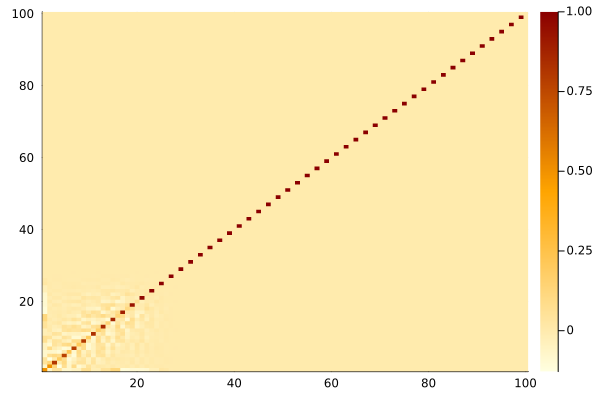

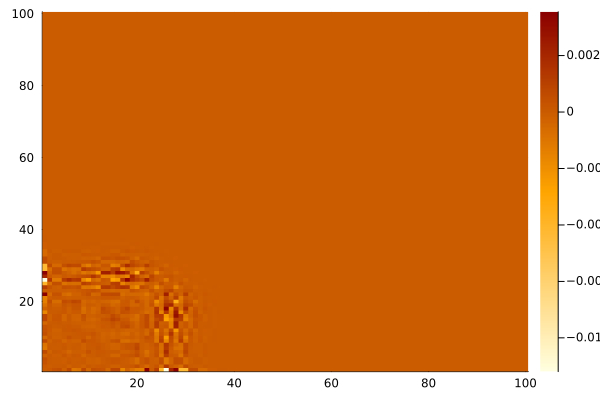

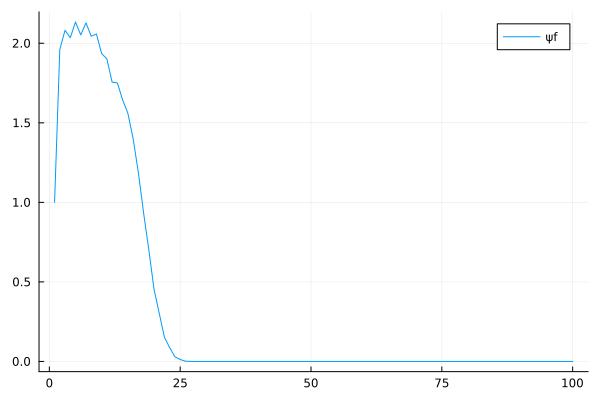

In [17]:
###Plotting of final state

num = expect(ψf,"n");
for j in sites
    println(rpad(j,6," "),num[j])
end


Cf = correlation_matrix(ψf,"Cdag","C");
gr()
display(heatmap(sites, sites, real(Cf), c = :heat))
fontsize = 10
nrow, ncol = size(Cf)
ann = [(i,j, text(round(real(Cf[i,j]), digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)


gr()
display(heatmap(sites, sites, real(Cf - Cf_test), c = :heat))
fontsize = 10
nrow, ncol = size(Cf)
ann = [(i,j, text(round(real(Cf[i,j]), digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)

SvN = entanglement_entropy(ψf);
display(plot(sites, SvN, label="ψf"))


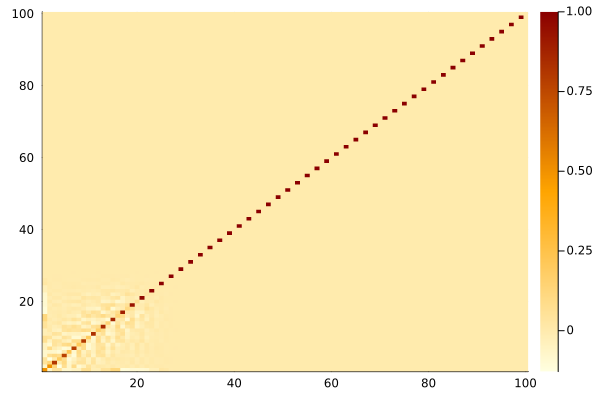

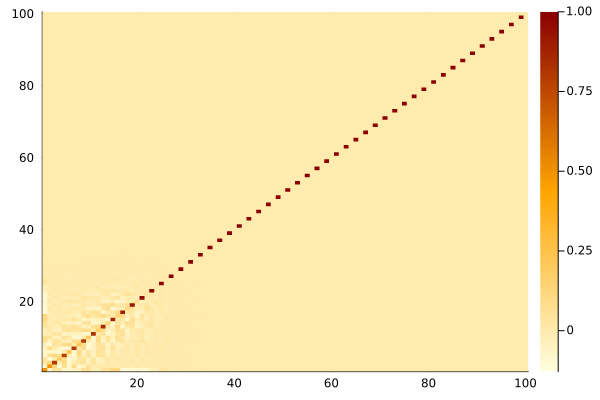

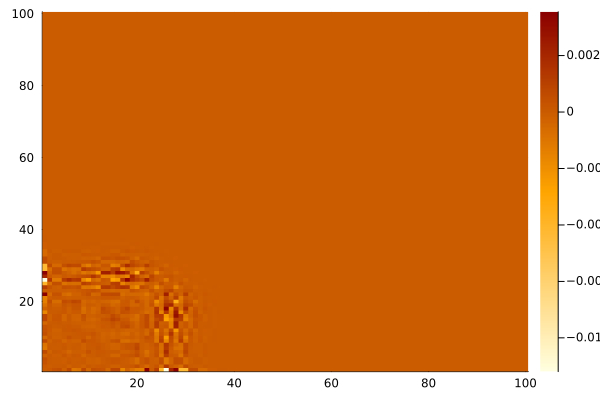

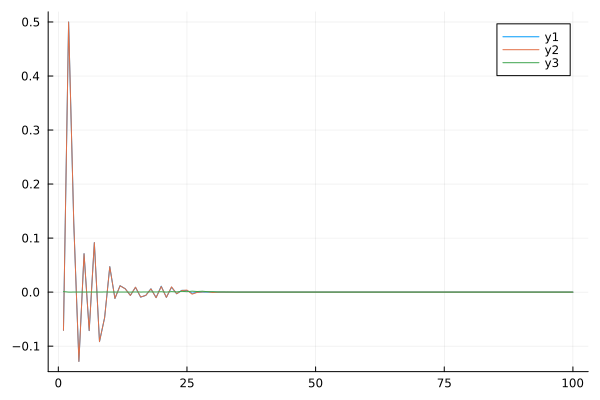

In [139]:

gr()
display(heatmap(sites, sites, real(Cf), c = :heat))
fontsize = 10
nrow, ncol = size(Cf)
ann = [(i,j, text(round(real(Cf[i,j]), digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)

gr()
display(heatmap(sites, sites, real(Cf_test), c = :heat))
fontsize = 10
nrow, ncol = size(Cf)
ann = [(i,j, text(round(real(Cf[i,j]), digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)




gr()
display(heatmap(sites, sites, real(Cf - Cf_test), c = :heat))
fontsize = 10
nrow, ncol = size(Cf)
ann = [(i,j, text(round(real(Cf[i,j]), digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)

plot(real(Cf[:,2]))
plot!(real(Cf_test[:,2]))
plot!(broadcast(abs,Cf[:,2]-Cf_test[:,2]))
